# Inference Pipeline

### Imports

In [2]:
import numpy as np
import h5py
import sys
import logging
sys.path.append('..')

# Neural network stuff
from fielutil import load_verbatimnet
from featextractor import extract_imfeats

# Logging
# logging.getLogger('featextractor').setLevel(logging.DEBUG)

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Parameters

In [16]:
# Do you want to load the features in? Or save them to a file?
load_features = True

# All the images that you require extraction should be in this HDF5 file
# hdf5images='icdar13data/benchmarking-processed/icdar_be.hdf5'
# hdf5images = 'icdar13data/experimental-processed/icdar13_ex.hdf5'
# hdf5images='nmecdata/nmec_scaled_flat.hdf5'
hdf5images='nmecdata/flat_nmec_bin_uint8.hdf5'

# This is the file that you will load the features from or save the features to
# featurefile = 'icdar13data/benchmarking-processed/icdar13be_fiel657.npy'
# featurefile = 'icdar13data/experimental-processed/icdar13ex_fiel657.npy'
featurefile = 'nmecdata/nmec_bw_fiel657_features_steps5_thresh.15.npy'
# featurefile = 'nmecdata/nmec_bw_fiel657_features_steps5_thresh.005.npy'

# This is the neural networks and parameters you are deciding to use
paramsfile = '/fileserver/iam/iam-processed/models/fiel_657.hdf5'

### Full image HDF5 file

Each entry in the HDF5 file is a full image/form/document

In [3]:
labels = h5py.File(hdf5images).keys()

### Load feature extractor neural network

In [ ]:
vnet = load_verbatimnet( 'fc7', paramsfile=paramsfile )
vnet.compile(loss='mse', optimizer='sgd')

Establishing Fiel's verbatim network
Loaded neural network up to fc7 layer

### Image features

Currently taken as averages of all shard features in the image. You can either load them or extract everything manually, depending on if you have the .npy array.

In [17]:
if load_features:
    print "Loading features in from "+featurefile
    imfeats = np.load(featurefile)
    print "Loaded features"
else:
    print "Begin extracting features from "+hdf5images
    imfeats = extract_imfeats( hdf5images, vnet, steps=(5,5), varthresh=0.15 )
    print h5py.File(hdf5images).keys()
    np.save( featurefile, imfeats )

Loading features in from nmecdata/nmec_bw_fiel657_features_steps5_thresh.15.npy
Loaded features


### Build classifier

In [5]:
imfeats = ( imfeats.T / np.linalg.norm( imfeats, axis=1 ) ).T
F = imfeats.dot(imfeats.T)
np.fill_diagonal( F , -1 )

### Evaluate classifier on HDF5 file 

You'll need to set the number of examples per image as follows:
1. IAM: Not Implemented
2. ICDAR 2013: g=4
3. NMEC: g=8

Two criteria matched are:
1. Precision (hard)
2. Recall (soft)

In [18]:
# Top k (soft criteria)
k = 10
# Max top (hard criteria)
maxtop = 2
# Number of examples per image
g = 8

# Run through the adjacency matrix
softcorrect = 0
hardcorrect = 0
totalnum = 0
for j, i in enumerate(F):
    topk = i.argsort()[-k:]
    # Soft criteria
    if j/g in topk/g:
        softcorrect += 1
    totalnum +=1
    # Hard criteria
    hardcorrect+= sum([1 for jj in (j/g == topk[-maxtop:]/g) if jj])
    
# Print out results    
print "Top %d (soft criteria) = %f" %( k, (softcorrect+0.0) / totalnum )
print "Top %d (hard criteria) = %f" %( k, (hardcorrect+0.0) / totalnum / maxtop )

Top 10 (soft criteria) = 0.362500
Top 10 (hard criteria) = 0.123611


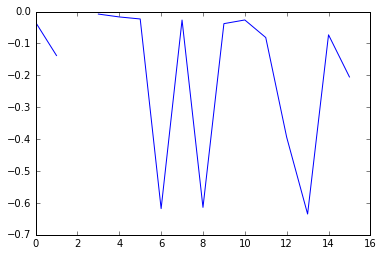

In [22]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(range(16),np.log(F[2][0:16]))